<Axes: >

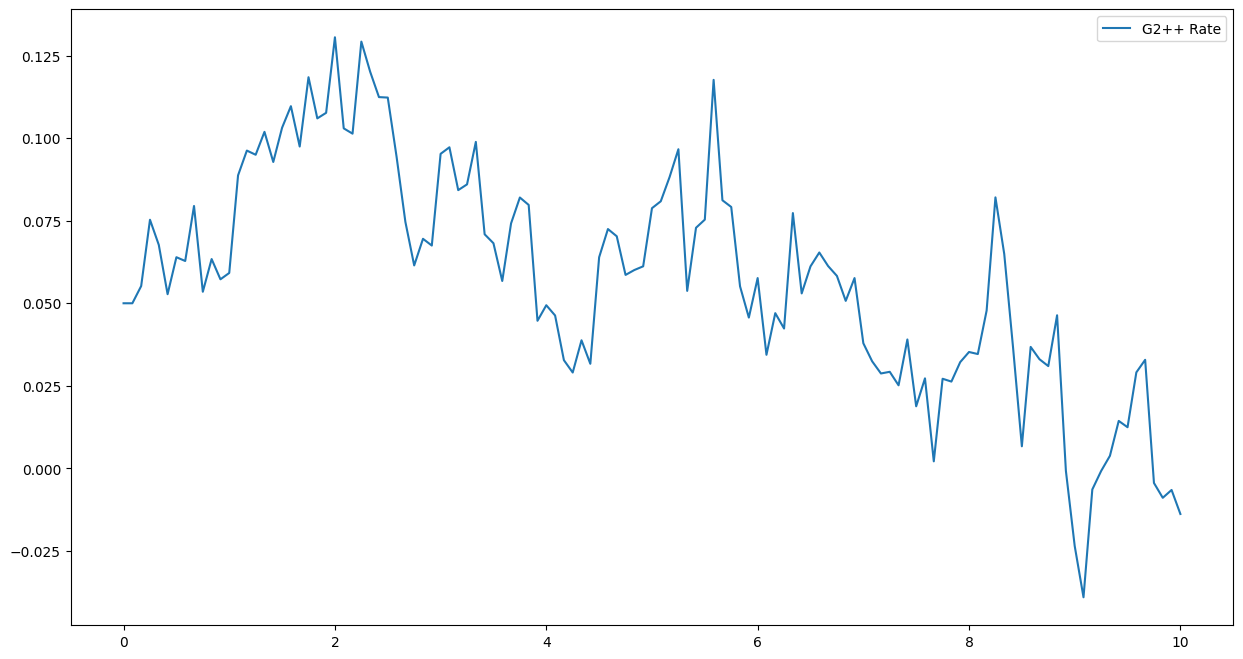

In [24]:
from dynamics import *
import seaborn as sns
import matplotlib.pyplot as plt
#Vasicek model
g2pp = G2PP(
    initial =0.05, 
    a       =1.1664,
    b       =0.0304,
    sigma   =0.0501,
    eta     =0.0084,
    rho     =-1.000)
time, rate, x, y = g2pp.create_path(stepsize=1/12, duration=10, seed=1999)
plt.figure(figsize=(15,8))
sns.lineplot(x=time, y=rate, label="G2++ Rate")


<Axes: >

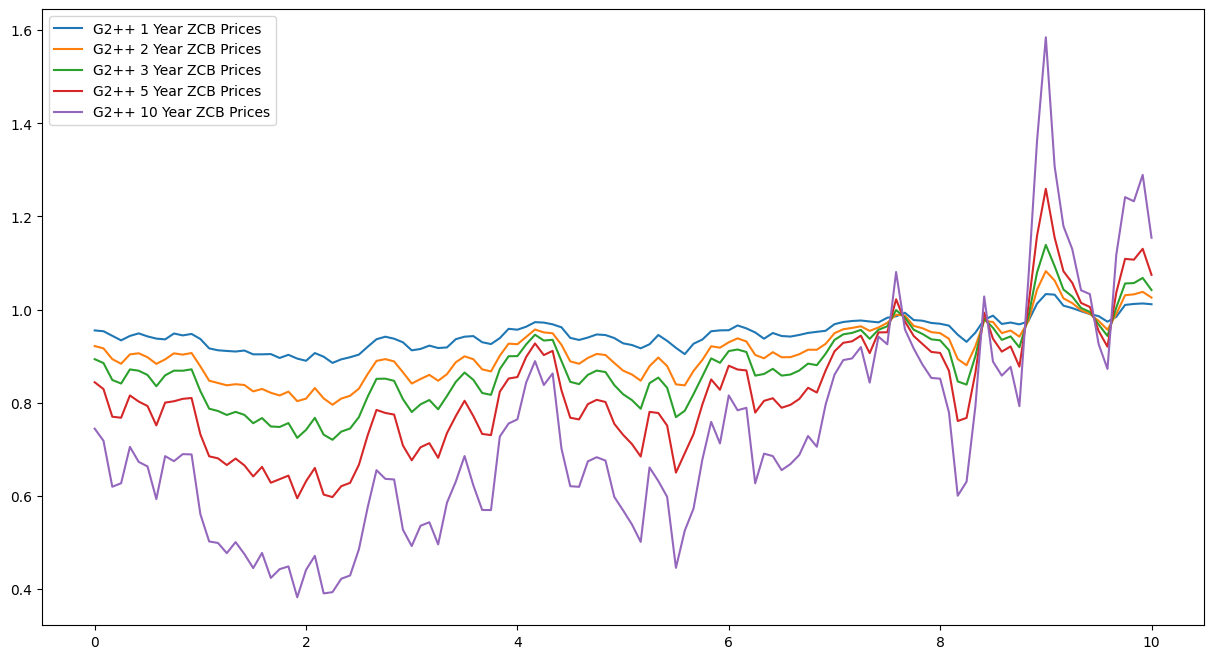

In [25]:
plt.figure(figsize=(15,8))
sns.lineplot(x=time, y=[g2pp.ZCB(1,x[i], y[i]) for i in range(len(x))], label = "G2++ 1 Year ZCB Prices")
sns.lineplot(x=time, y=[g2pp.ZCB(2,x[i], y[i]) for i in range(len(x))], label = "G2++ 2 Year ZCB Prices")
sns.lineplot(x=time, y=[g2pp.ZCB(3,x[i], y[i]) for i in range(len(x))], label = "G2++ 3 Year ZCB Prices")
sns.lineplot(x=time, y=[g2pp.ZCB(5,x[i], y[i]) for i in range(len(x))], label = "G2++ 5 Year ZCB Prices")
sns.lineplot(x=time, y=[g2pp.ZCB(10,x[i], y[i]) for i in range(len(x))], label = "G2++ 10 Year ZCB Prices")

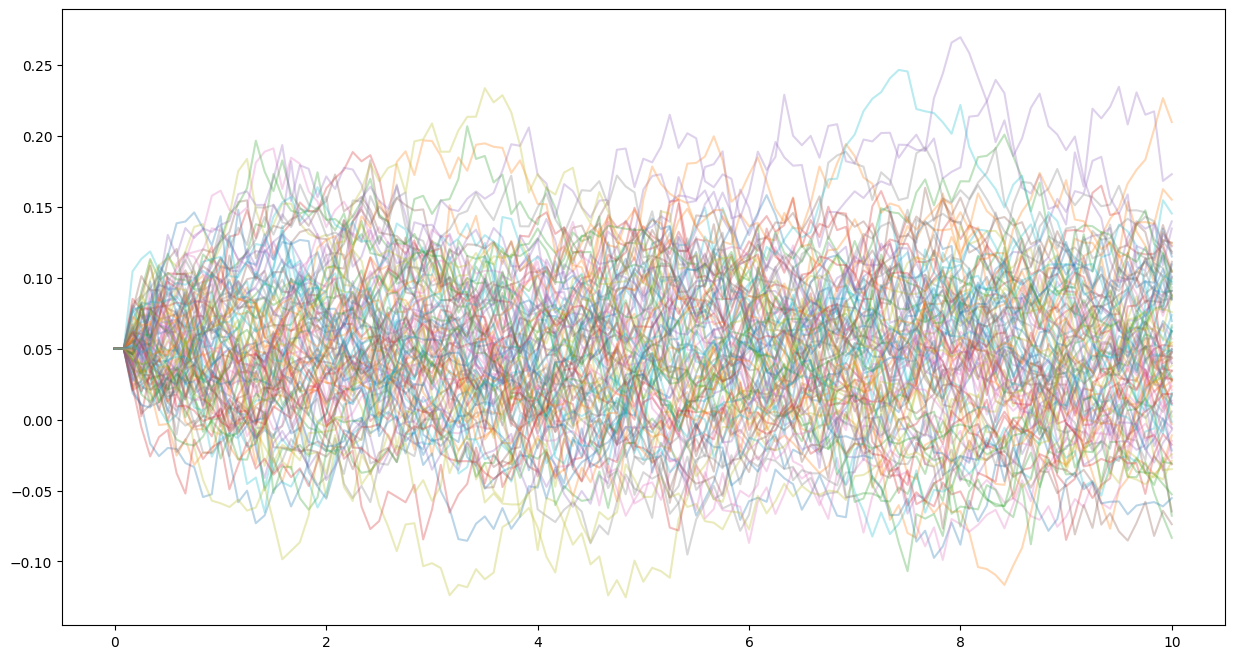

In [26]:
plt.figure(figsize=(15,8))
for i in range(100):
    time, rate, x, y = g2pp.create_path(stepsize=1/12, duration=10, seed=i)
    sns.lineplot(x=time, y=rate, alpha=0.3)
# sns.lineplot(x=time, y=expected, label="Vasicek Expected Short Rate", c='red')

<Axes: xlabel='Expiry'>

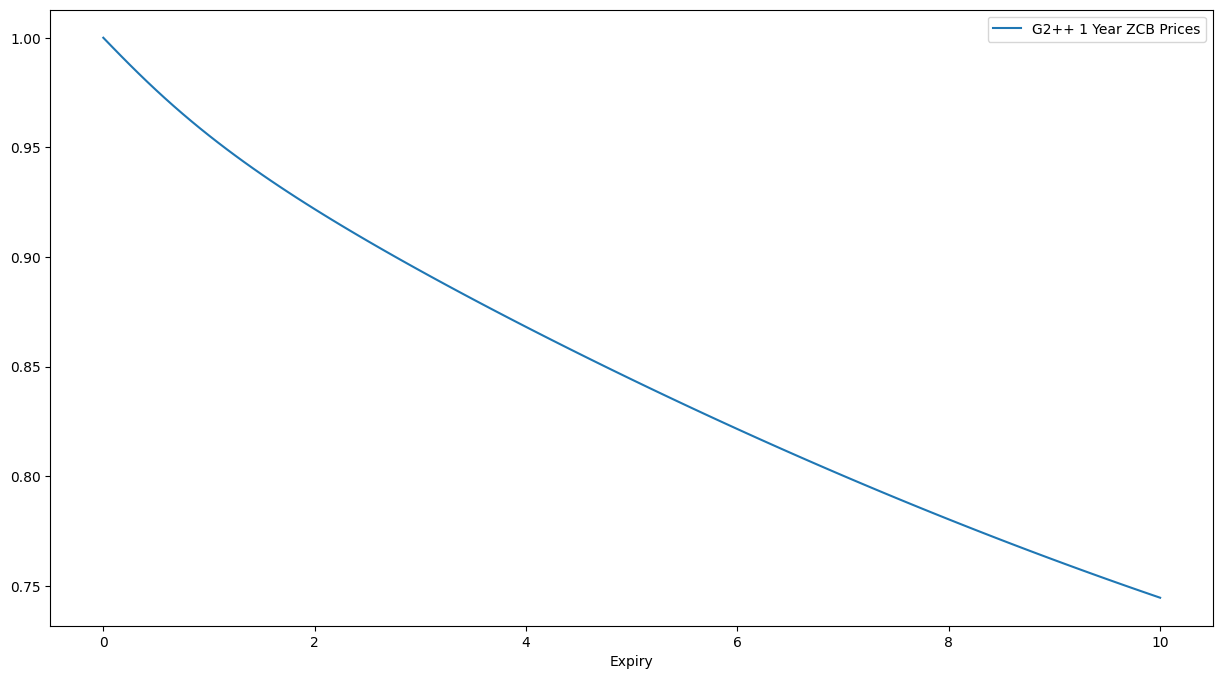

In [27]:
plt.figure(figsize=(15,8))
plt.xlabel("Expiry")
sns.lineplot(x=time, y=[g2pp.ZCB(t,0, 0) for t in time], label = "G2++ 1 Year ZCB Prices")

In [28]:
from products import *
from scipy import optimize
fixSchedule = np.arange(0,10+1)
floSchedule = np.arange(0,20+1)/2
time, floatRate, x, y = g2pp.create_path(1/12, 10, 1999)
# (Non analytical way to find par swap rate)
# K = parSwapRate(
#     fixedSchedule=fixSchedule, 
#     floatingSchedule=floSchedule,
#     rate=g2pp.init, 
#     model=g2pp)
K=0.04
plt.figure(figsize=(15,8))
sns.lineplot(x=time, y=floatRate, label='Floating Rate')
sns.scatterplot(x=floSchedule, y=floatRate[0::6], label='Receiving of Floating Rate', c='red')
sns.scatterplot(x=fixSchedule, y=np.repeat(K, len(fixSchedule)), label=f'Payment of Fixed Rate (K={round(K,4)})', c='green')

ValueError: too many values to unpack (expected 2)